# Introduction

In this notebook we will develop a model to predict the hourly generation of solar and wind power in the German bidding zone (DE-AT-LU). The models will feed on two-dimensional grid weather data from a cosmological reanalysis from the year 2015 by the German National Weather Agency (DWD). The predicted data will be the true hourly generation output of the respective technologies in the German bidding zone, available from the German Transmission system operators.

> **Note**: The datasets used in this model are quite big (~10GB in total). Running parts of this notebook will require large amounts of memory to keep the respective numpy arrays in memory. All of this code has been executed on a AWS p2.xlarge instance with 64GB of RAM. The minimum memory required is unknown. 8GB is certainly not enough...

> **Note**: Weather data is originally provided in the .grib format. There are python libraries to handle .grib files, in this case the iris library was used. Installing this module and the respective dependencies is a pain. Thus, all data is preprocessed and saved as binary numpy arrays. However, to execute the iris code in this notebook (optional, for exemplary purposes only!), you will have to install the library first. The best option would be to have a separate environment for iris, since it requires python 2.6. You will have to execute the optional part of this notebook with the iris-environment. The rest of the notebook requires keras und python 3.6+. This is a bit inconvenient but necessary for explanatory purposes.

## Contents


* [Step 0](#step0): Visualize grid weather data with iris (optional)
* [Step 1](#step1): Preprocess data
* [Step 2](#step2): Train a neural network for solar power generation
* [Step 3](#step3): Train a neural network for wind power generation
---

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import preprocessing as prep
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Conv2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from functools import reduce

%matplotlib inline

Using TensorFlow backend.


<a id='step0'></a>
# Visualize grid weather data with iris (optional)

In [2]:
import iris
import time
import bz2
import wget

from __future__ import (absolute_import, division, print_function)
from six.moves import (filter, input, map, range, zip)

import matplotlib.pyplot as plt

import iris
import iris.quickplot as qplt
import cartopy.feature as feature

The next cells will download weather data from the German weather service ftp server. Since the original file is ~500MB, this might take a while. Expect up to 15 minutes, depending on the mood of the ftp server. This exemplary file contains grid data for solar radiation in Europe for September 2015 in hourly resolution. It is compressed and saved in a .grib binary file. The following code will download and decompress the data and load it into an iris.cube object. Cubes are multi-dimensional data objects. In our case we have two spatial dimensions (latitude and longitude) and a third temporal dimension (hours). We will extract an exemplary grid data subset for the 12th hour of September 2015, cut out a sub-grid that spans Germany and visualize the two-dimensional grid in a contour-plot.

In [3]:
# path for original direct solar radiation data for September 2015
path = 'ftp://ftp-cdc.dwd.de/pub/REA/COSMO_REA6/hourly/2D/SWDIRS_RAD/SWDIRS_RAD.2D.201509.grb.bz2'

# save data file to this path
raw_out = './raw_data/grib/'

In [ ]:
# download file. this might take a while (~12 mins for ~400MB file)
_ = wget.download(path, out=raw_out)

In [4]:
filename = raw_out + 'SWDIRS_RAD.2D.201509.grb.bz2'

# open and decompress file
zipfile = bz2.BZ2File(filename)
data = zipfile.read()

In [ ]:
# load the data into a iris.cube
cubes = iris.load_cube(data)
print(cubes)

In [ ]:
# get exemplary data for hour 12 of day one, September 2015
testcube = cubes[12]

# print timestamp in data
print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(testcube.coords('time')[0].cell(0).point.round()*3600)))

**Explanation**

The original .grib dataset contains a grid of 5x5km cells spanning all of Europe for every hour in the respective month. Every cell contains a numerical value for the respective variable (here: direct solar radiation). The data can be accessed like a 2D numpy array by indexing rows and columns, which resemble longitude and latitude steps of the grid. The grid dimensions spanning Germany have been used to cut out the weather data for the German area. 

This visualization is just an example. Grid data for all weather variables has been downloaded and stored as numpy.ndarray binary objects for better accessibility. See readme.md for more information about how to acquire the numpy formatted weather data.

In [ ]:
f, ax = plt.subplots(figsize=(15,15))

# Draw the contourplot for the sub-grid that spans Germany. 
ax = qplt.contourf(cubes[12][365:510, 375:485])

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().add_feature(feature.BORDERS, linestyle='-', alpha=.5)

plt.show()

<a id='step1'></a>
# Preprocess data

The goal of this model is to predict solar and wind power generation in Germany for the year 2015. Generation data is available as actual generation for each hour of a day, and as generation _forecasts_ that are published by German Transmission System Operators the day before. German electricity prices in the Day-Ahead market, the final variable we want to predict, using solar and wind power generation as inputs, is dependent on the _expected share of generation_ of each technology (coal, nuclear, wind, solar etc.). Predicting actual generation for a certain day might actually yield worse results than predicting expected generation, since these expectations might be different from actual generation due to unexpected weather conditions. Or in other words: Players in the electricity market have expectations about the renewable generation for the next day. These expectations determine the Day-Ahead price. However, actual generation might deviate from these expectations. Predicting actual generation is only a proxy for expected generation. The better the forecasting capabilities of the market players, the closer expected generation and actual generation are to each other. 

> **Note**: The information used in these models is actually not available in a real world setting. What we do here is predicting _realized_ generation levels based on _realized_ (measured) weather conditions for every hour of a day. In a real world application we would have to predict _expected_ generation levels based on _forecasted_ weather conditions (e.g. by weather services). Since no historical weather forecasts are available, we have to use measured weather data to show the validity of the approach. However, it is not necessarily true, that the predictions in a real world setting with enough forecast data available will perform worse. If all market players use a similar weather forecast to base their expectation on, then this particular forecast will be as good for predicting expected generation as measured weather data is for realized generation. It is reasonable to assume that a model trained on measurement data is able to generalize to forecasting data, given the assumption that market players are, in general, doing a good job with their own models for predicting their individual expected generation.

In [1]:
# read preprocessed generation data for the german bidding zone
labels = pd.read_csv('./processed_data/20150101-20170830-gen_per_prod_type.csv', parse_dates=True, index_col=0)

# drop duplicates in the data, keep last entry
labels.drop_duplicates(keep='last', inplace=True)

# resample to 1 hour steps, since weather data is only available in hourly resolution. Take mean, since generation 
# data unit is Watt (power)
labels = labels.resample('1H').mean()


NameError: name 'pd' is not defined

> **Note**: Weather data and generation data are indexed in a different manner. A day in the generation dataset starts at 00:00:00 while a day in the weather data set starts at 01:00:00 - both referencing the 'first hour of a day'. We shift the generation data in order to align the  indices of both datasets.

In [ ]:
# shift labels by one hour
labels = labels.shift(-1)
labels = labels['2015']

In [4]:
labels.head()

,biomass,brown_coal,hard_coal,wind_offshore,pumped_hydro,solar,river_hydro,wind_onshore,nuclear,other
MTU,,,,,,,,,,
2015-01-01 00:00:00,4261.00,15364.75,1929.75,516.25,409.50,0.0,2617.00,8367.5,11086.25,4743.50
2015-01-01 01:00:00,4295.50,14852.75,1824.00,514.00,632.75,0.0,2578.75,8604.0,11026.25,4836.50
2015-01-01 02:00:00,4313.75,14111.00,1959.00,517.75,558.25,0.0,2545.25,8617.0,11027.75,4840.25
2015-01-01 03:00:00,4308.50,14149.00,2012.25,519.75,602.75,0.0,2557.75,8707.5,10962.25,4820.75
2015-01-01 04:00:00,4304.00,13509.50,1753.50,520.00,629.25,0.0,2554.75,8775.5,10696.00,4958.00


<a id='step2'></a>
# Train a neural network for solar power generation

We will use diffuse and direct solar radiation data as well as total precipitation as input variables for our photovoltaic generation model. Solar radiation is used for obvious reasons. Total precipitation is a proxy variable for cloudiness, which has a major influence on the amount and 'quality' of radiation that reaches a solar panel. 

In [6]:
# define weather variables
VARS = ['SWDIFDS_RAD', 'SWDIRS_RAD', 'TOT_PRECIP']

> **Careful**: The next step requires a lot of RAM!

In [7]:
# read data from numpy arrays, generate indices provided with original data
indices, tensors = prep.prepare_training_data(range(1, 13, 1), VARS)

In [8]:
# Check for missing data. Dict entries show indexes of each variable, that are not present in the union of the indices
# of all variables.
prep.check_indices(indices)

{'SWDIFDS_RAD': DatetimeIndex(['2016-01-01 02:00:00'], dtype='datetime64[ns]', name=0, freq=None),
 'SWDIRS_RAD': DatetimeIndex(['2016-01-01 02:00:00'], dtype='datetime64[ns]', name=0, freq=None),
 'TOT_PRECIP': DatetimeIndex(['2015-01-01 01:00:00', '2015-01-01 04:00:00',
                '2015-01-01 05:00:00', '2015-01-01 07:00:00',
                '2015-01-01 10:00:00', '2015-01-01 11:00:00',
                '2015-01-01 13:00:00', '2015-01-01 16:00:00',
                '2015-01-01 17:00:00', '2015-01-01 19:00:00',
                ...
                '2015-12-30 19:00:00', '2015-12-30 23:00:00',
                '2015-12-31 01:00:00', '2015-12-31 05:00:00',
                '2015-12-31 07:00:00', '2015-12-31 11:00:00',
                '2015-12-31 13:00:00', '2015-12-31 17:00:00',
                '2015-12-31 19:00:00', '2015-12-31 23:00:00'],
               dtype='datetime64[ns]', name=0, length=3888, freq=None)}

**Explanation**

We can see that a lot of datapoints in the TOT_PRECIP dataset are missing. If we have a look at the actual timestamps in the real data (.txt files in the raw data), we can observe that they have a lot of duplicated indices and the whole indexation is generally messed up. The amount of samples however fits the expected amount, which is 8760 hours for the whole year. Including this data has actually improved the model. It is imaginable, that just the indexing of the original data is messed up, while the values are actually sorted correctly. We will use this data in the upcoming steps, although the indexing seems messy.

We do not have to care for the 'missing' values for SWDIFDS_RAD and SWDIRS_RAD, since these values are only present in the erroneous index of TOT_PRECIP.

In [9]:
# double check on data dimensions. 8760 hours, 145 longitude steps, 110 latitude steps.
for t in tensors.values():
    print(t.shape)

(8760, 145, 110)
(8760, 145, 110)
(8760, 145, 110)


In [10]:
# grab first data index (belonging to SWDIFDS_RAD) as reference index
index = indices[0]

In [11]:
# series of actual solar generation in Germany for each hour of the year
output = labels.solar.to_frame()

In [12]:
len(output)

8760

In [ ]:
sum(output.isnull())

Some generation data (outputs) is missing (~30 hours). We will exclude the weather data for the respective hours

> **Careful**: The next step requires a lot of RAM!

In [ ]:
# scale to 0-1 range
scaler = MinMaxScaler()

# stack all features into one big numpy array of shape (hours, long, lat, variables). Exclude samples without outputs.
stacked_features, output, index = prep.align_transform_data(output.solar, tensors, VARS, scaler, index)

> **Careful**: The next step requires a lot of RAM!

In [ ]:
# double check correct feature shape
stacked_features.shape

In [22]:
# Split data while keeping whole days intact within one subset. Intact days will yield more beautiful visualizations
# than randomly chosen hours from all hours of a year.
X_train, X_valid, X_test, y_train, y_valid, y_test = prep.daily_train_valid_test_split(stacked_features, output,
                                                                                  index,
                                                                                  ret_test_index=False)

The number of samples constitutes the number of hours in a year. Width and height are longitude and latitude steps in the chosen grid. Each variable (direct and diffuse radiation, precipitation) is represented by one channel.

In [31]:
# extract dimensions
samples, w, h, channels = (stacked_features.shape[i] for i in range(4))

**Idea**

The challenge we in this particular problem is to efficiently handle the high dimensional input space. We have three different input channels with 145x110 = 15950 grid entries each, in every sample. We will use a convolutional neural network to reduce the input dimensionality. The first convolutional layer will just increase the size of a grid cell to 10x10 km by applying a symmetrical kernel size and stride of 2, while providing a high number of feature maps to cover a variety of possible input channel combinations. The second layer will reduce the grid dimensionality further. All of the resulting grid cells are flattened to a vector which is then used as an input for a densely connected layer. The effect of solar radiation (or weather conditions in general) in a particular cell will have a different impact on the generation level, depending on how much photovoltaic power plants are installed in this particular region of Germany. The idea is, that the weights in the dense layer represent this heterogenous distribution of generation capacity.

In [82]:
# design neural network architecture
input_layer = Input(shape=(w, h, channels))
x = Conv2D(64, activation='relu', kernel_size=(2, 2), strides=(2, 2), padding='same')(input_layer)
x = Conv2D(12, activation='relu', kernel_size=(5,5), strides=(5,5))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='relu')(x)
model = Model(inputs=input_layer, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 145, 110, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 73, 55, 64)        832       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 11, 12)        19212     
_________________________________________________________________
flatten_10 (Flatten)         (None, 1848)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                118336    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 138,445
Trainable params: 138,445
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [84]:
# train model, save best performing model (on validation set) for future steps 
checkpoint = ModelCheckpoint('./models/renewable_pred_solar.hdf5', save_best_only=True)
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint])

Train on 6480 samples, validate on 1224 samples
Epoch 1/10
6480/6480 [==============================] - 5s - loss: 0.0113 - mean_absolute_error: 0.0597 - val_loss: 0.0098 - val_mean_absolute_error: 0.0556
Epoch 2/10
6480/6480 [==============================] - 4s - loss: 0.0080 - mean_absolute_error: 0.0504 - val_loss: 0.0080 - val_mean_absolute_error: 0.0485
Epoch 3/10
6480/6480 [==============================] - 4s - loss: 0.0067 - mean_absolute_error: 0.0460 - val_loss: 0.0052 - val_mean_absolute_error: 0.0398
Epoch 4/10
6480/6480 [==============================] - 4s - loss: 0.0053 - mean_absolute_error: 0.0406 - val_loss: 0.0053 - val_mean_absolute_error: 0.0408
Epoch 5/10
6480/6480 [==============================] - 4s - loss: 0.0050 - mean_absolute_error: 0.0395 - val_loss: 0.0051 - val_mean_absolute_error: 0.0414
Epoch 6/10
6480/6480 [==============================] - 4s - loss: 0.0045 - mean_absolute_error: 0.0378 - val_loss: 0.0045 - val_mean_absolute_error: 0.0379
Epoch 7/10

In [85]:
# load best model and predict for test set
model = load_model('./models/renewable_pred_solar.hdf5')
pred = model.predict(X_test)

In [2]:
# save results in data frame for easy plotting
df = pd.DataFrame({'predicted generation':pred.flatten(), 'true generation':y_test.flatten()})

NameError: name 'pd' is not defined

In [87]:
# calculate mean squared error on the test set
print(mean_squared_error(y_test, pred))

0.00365797660624


**Analysis**

The mean squared error on the test set is comparable to the performance of the model on the validation set during training. We have seen a validation loss (mean squared error) of 0.0033 while the error on the test set is 0.0036. It seems like the model is able to generalize on unseen data. A mean squared error metric is somewhat hard to grasp, so we will plot the results on the test set.



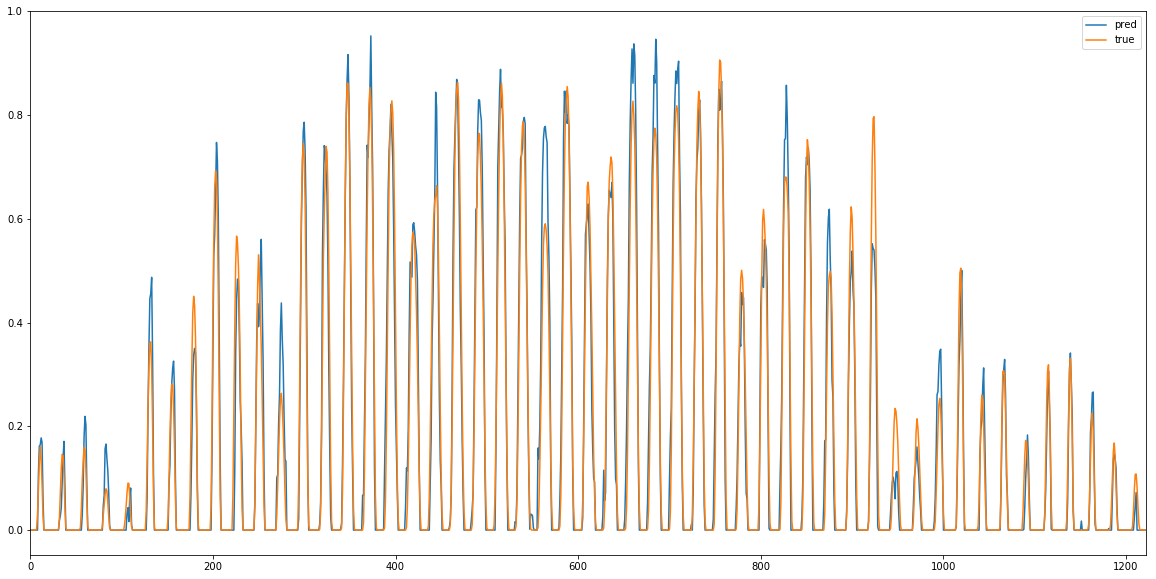

In [88]:
# plot results
fig, ax = plt.subplots(figsize=(20,10))
df.plot(ax=ax)
ax.set_title('Predicted and true solar power generation in Germany')
ax.set_ylabel('Generation level')
ax.set_xlabel('Test set index')

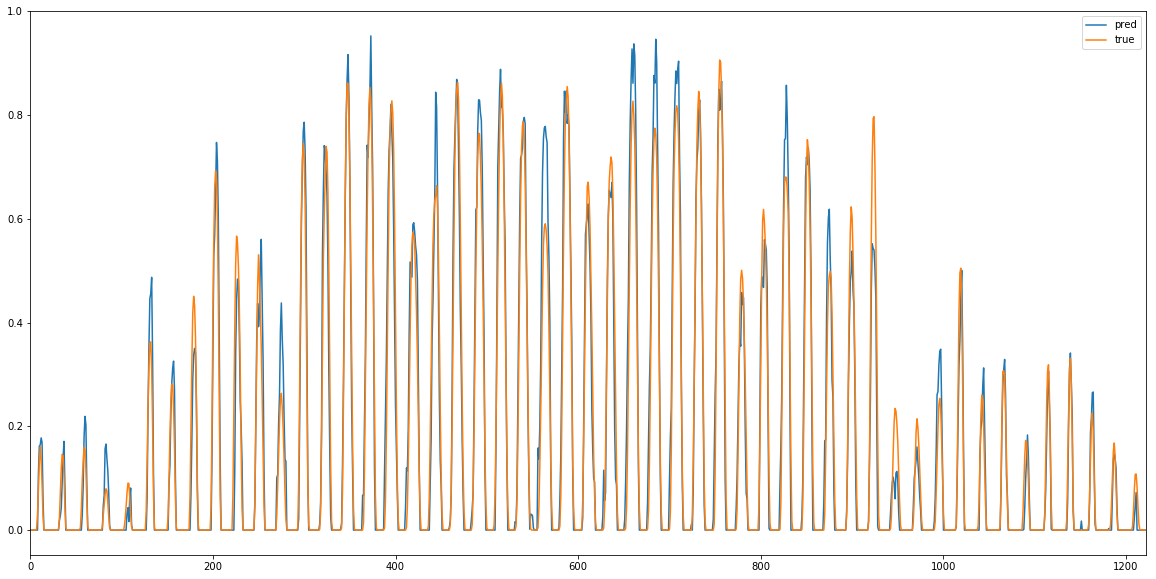

In [88]:
# plot results
fig, ax = plt.subplots(figsize=(20,10))
df.iloc[400:600].plot(ax=ax)
ax.set_title('Predicted and true solar power generation in Germany')
ax.set_ylabel('Generation level')
ax.set_xlabel('Test set index')

**Analysis**

I have to admit that this result surprised me a little bit. The model is quite good in predicting the overal solar generation for the testset. There are some samples in which the model over- or underpredicts by a fair amount. But the general magnitude as well as the day-and-night cycles are quite accurate. Note that the ReLu activation function comes in quite handy for modeling photovoltaic generation (or generation in general), because it only allows positive data.

We will use this model to predict solar generation for all available samples in 2015 and save them as indexed bottleneck features for higher level models

In [2]:
# create indexed bottleneck features for all available input samples to use as inputs for other models
full = model.predict(stacked_features)
full = scaler.inverse_transform(full)
df = pd.Dataframe({'solar_fromtrue':full}, index=indices[0])
df.to_csv('./bottleneck_features/bnf_solar.csv')

NameError: name 'model' is not defined

<a id='step3'></a>
# Train a neural network for wind power generation

> **Note**: The wind power generation model will rely on the same steps as the solar generation model. Please refer to the above explanations for the different steps and code explanations. 

Wind does not only have a velocity, but also a direction. Hence, wind is best described by a vector representation. The available wind data contains measurements of _zonal velocity_ **U**, i.e. the component of the wind towards east, and _meridional velocity_ **V**, i.e. the component of the wind towards north. It is important to include both variables, since the overall length of the wind vector is composed of its zonal _and_ meridional component. 

Solar generation follows a very homogenous pattern. Over a large enough area, where local weather conditions are averaged out, it follows a very smooth, sinusoidal pattern, that mainly varies in magnitude in between days, as well as starting and ending points, dependent on hours of sunset and sunrise. Wind is **much** more volatile. To my best knowledge, there is no 'pattern' in wind speed or direction, except for maybe higher overall wind levels in spring and fall. Furthermore, we only have wind measurements in 10m height. Wind itself is a very three-dimensional variable, which varies substantially in different heights. Most modern wind power generators operate in heights well above 50m. At this point, it is unknown whether wind speed in 10m height is an appropriate proxy for wind speed in other heights. Since it is the only data available, we will use it nontheless and hope for the best. For the above mentioned reasons, I expect the wind power prediction to be much less precise than the solar power prediction. 

In [30]:
# select variables
VARS = ['U_10M', 'V_10M']

> **Careful**: The next step requires a lot of RAM!

In [31]:
# read data into memory
indices, tensors = prep.prepare_training_data(range(1, 13, 1), VARS)

In [32]:
# check for missing indices
prep.check_indices(indices)

{'U_10M': Index([], dtype='object', name=0),
 'V_10M': Index([], dtype='object', name=0)}

In [33]:
# check correct feature dimensions
for t in tensors.values():
    print(t.shape)

(8760, 145, 110)
(8760, 145, 110)


In [34]:
# define reference index
index = indices[0]

In [3]:
# aggregate onshore and offshore generation
labels['sum_wind'] = labels.wind_onshore + labels.wind_offshore

NameError: name 'labels' is not defined

In [92]:
# extract labels
output = labels.sum_wind.to_frame()

> **Careful**: The next step requires a lot of RAM!

In [ ]:
# scale labels to 0-1 range, stack input features into one big numpy array
scaler = MinMaxScaler()
stacked_features, output, index = align_transform_data(output.sum_wind, tensors, VARS, scaler, index)

> **Careful**: The next step requires a lot of RAM!

In [107]:
# split data into subsets
X_train, X_valid, X_test, y_train, y_valid, y_test = prep.daily_train_valid_test_split(stacked_features, output,
                                                                                  index,
                                                                                  ret_test_index=False)

In [108]:
# define data dimensions
samples, w, h, channels = (stacked_features.shape[i] for i in range(4))

In [109]:
# define neural network architecture
input_layer = Input(shape=(w, h, channels))
x = Conv2D(64, activation='relu', kernel_size=(2, 2), strides=(2, 2), padding='same')(input_layer)
x = Conv2D(12, activation='relu', kernel_size=(5,5), strides=(5,5))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='relu')(x)
model = Model(inputs=input_layer, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 145, 110, 2)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 73, 55, 64)        576       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 11, 12)        19212     
_________________________________________________________________
flatten_11 (Flatten)         (None, 1848)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                118336    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 138,189
Trainable params: 138,189
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [111]:
# train neural network, save best performance on validation set
checkpoint = ModelCheckpoint('./models/renewable_pred_wind.hdf5', save_best_only=True)
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint])

Train on 6503 samples, validate on 1224 samples
Epoch 1/10
6503/6503 [==============================] - 4s - loss: 0.0074 - mean_absolute_error: 0.0617 - val_loss: 0.0043 - val_mean_absolute_error: 0.0493
Epoch 2/10
6503/6503 [==============================] - 4s - loss: 0.0035 - mean_absolute_error: 0.0440 - val_loss: 0.0034 - val_mean_absolute_error: 0.0453
Epoch 3/10
6503/6503 [==============================] - 4s - loss: 0.0031 - mean_absolute_error: 0.0415 - val_loss: 0.0033 - val_mean_absolute_error: 0.0430
Epoch 4/10
6503/6503 [==============================] - 4s - loss: 0.0027 - mean_absolute_error: 0.0386 - val_loss: 0.0033 - val_mean_absolute_error: 0.0430
Epoch 5/10
6503/6503 [==============================] - 4s - loss: 0.0019 - mean_absolute_error: 0.0327 - val_loss: 0.0028 - val_mean_absolute_error: 0.0411
Epoch 6/10
6503/6503 [==============================] - 4s - loss: 0.0017 - mean_absolute_error: 0.0312 - val_loss: 0.0031 - val_mean_absolute_error: 0.0427
Epoch 7/10

In [112]:
# predict outputs for unseen data
model = load_model('./models/renewable_pred_wind.hdf5')
pred = model.predict(X_test)

In [113]:
df = pd.DataFrame({'predicted generation':pred.flatten(), 'true generation':y_test.flatten()})

In [114]:
# mean squared error on test set
print(mean_squared_error(y_test, pred))

0.00232165779619


**Analysis**

The mean squared error on the test set is comparable to the performance of the model on the validation set during training. We have seen a validation loss (mean squared error) of 0.0026 while the error on the test set is 0.0023. It seems like the model is able to generalize on unseen data. A mean squared error metric is somewhat hard to grasp, so we will plot the results on the test set. It is very surprising, that the error levels are **below** solar generation prediction errors (the two are comparable, since all outputs have been scaled to 0-1 range!). It seems like the wind power model is more precise than the solar model. Lets see what this means visually.

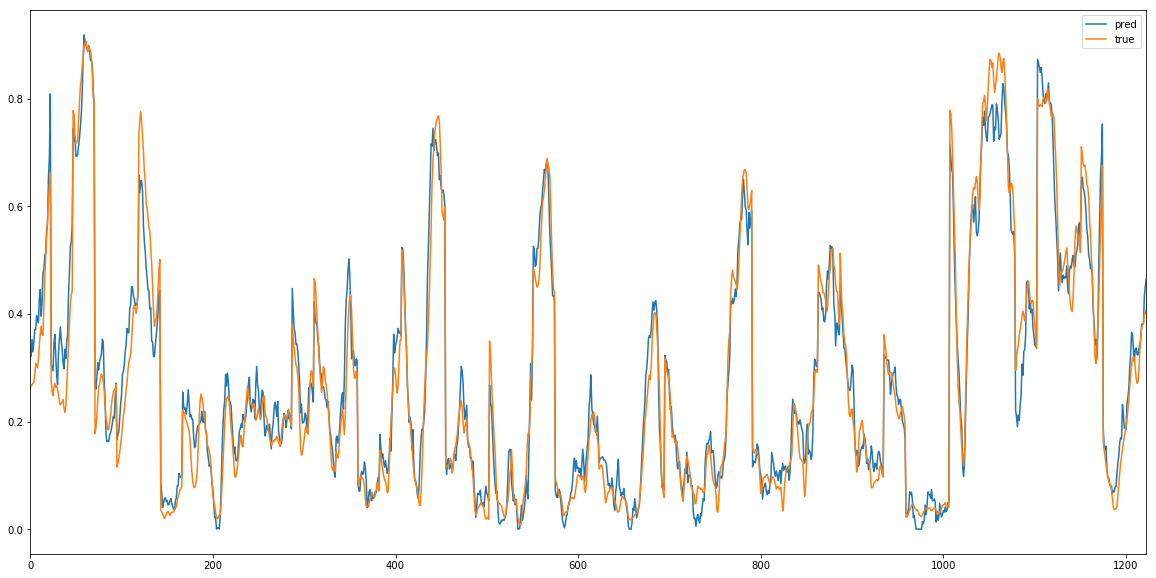

In [115]:
fig, ax = plt.subplots(figsize=(20,10))
df.plot(ax=ax)
ax.set_title('Predicted and true solar wind power generation in Germany')
ax.set_ylabel('Generation level')
ax.set_xlabel('Test set index')

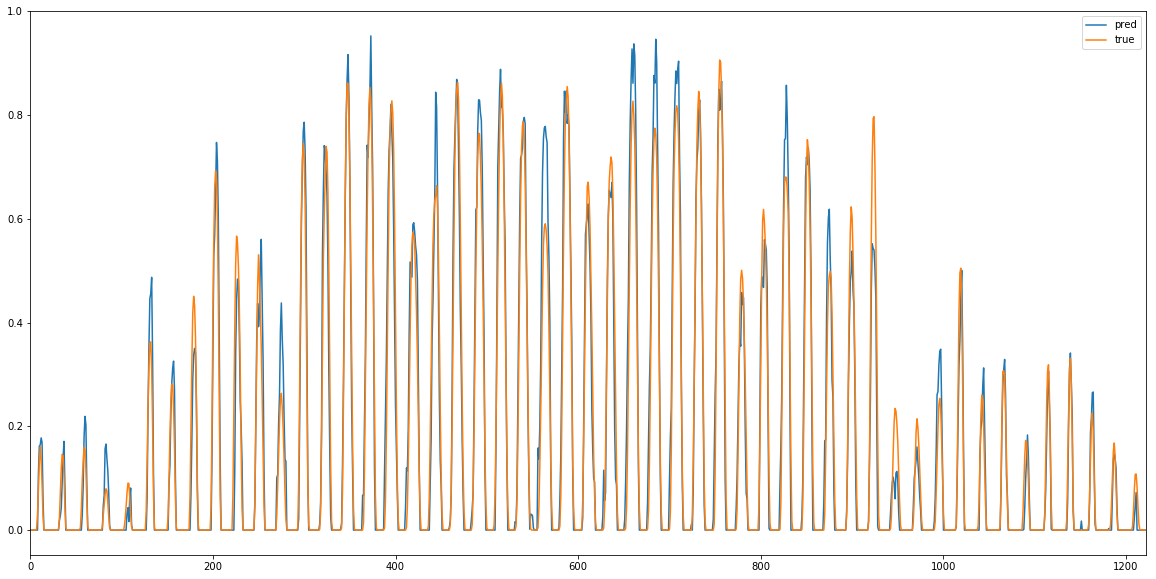

In [88]:
# plot results
fig, ax = plt.subplots(figsize=(20,10))
df.iloc[400:600].plot(ax=ax)
ax.set_title('Predicted and true wind power generation in Germany')
ax.set_ylabel('Generation level')
ax.set_xlabel('Test set index')

**Analysis**

Again, way better than I initially expected! There are some non-negligible errors in the prediction, but the overall levels and trends are surprisingly well matched.

We will use this model to predict wind power generation for all available samples in 2015 and save them as indexed bottleneck features for higher level models

In [ ]:
full = model.predict(stacked_features)
full = scaler.inverse_transform(full)
df = pd.Dataframe({'wind_fromtrue':full}, index=index[0])
df.to_csv('./bottleneck_features/bnf_wind.csv')